# Actor-Based Backtesting with Portfolio Management

This notebook demonstrates using the `trade-engine` (actor-based) for backtesting. 
We implement a strategy using standard technical indicators with a strict portfolio management constraint:
- Max 20 concurrent positions (slots).
- 1/20th (5%) allocation per position.
- New entry signals are ignored if all slots are full.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import uuid
from sqlalchemy import create_engine, StaticPool

# 1. Setup Engine Paths
engine_root = os.path.abspath("../another_testing_engine/trade-engine/trade-engine")
if engine_root not in sys.path:
    sys.path.append(engine_root)

from tradeengine.actors.memory import MemPortfolioActor
from tradeengine.actors.sql import SQLOrderbookActor
from tradeengine.backtest import BacktestStrategy
from tradeengine.dto import Asset

print("Engine components imported successfully.")

Engine components imported successfully.


## Data Loading
We load multiple assets to test the portfolio slot management.

In [2]:
data_dir = "../dataset/cleaned"
asset_files = sorted([f for f in os.listdir(data_dir) if f.startswith("Asset_") and f.endswith(".csv")])[:30]
assets = [f.split(".")[0] for f in asset_files]

dfs = {}
for a, f in zip(assets, asset_files):
    path = os.path.join(data_dir, f)
    df = pd.read_csv(path, parse_dates=True, index_col="Date")
    dfs[a] = df.sort_index()

print(f"Loaded {len(dfs)} assets.")

Loaded 30 assets.


## Technical Indicators & Signal Generation
We'll use a combined strategy:
- **Golden Crossover**: SMA 50 > SMA 200
- **MACD**: MACD Line > Signal Line
- **RSI Mean Reversion**: Buy < 30, Sell > 70

**Entry Condition**: Golden Crossover OR (RSI < 30 and MACD > Signal)
**Exit Condition**: RSI > 70 OR (SMA 50 < SMA 200 and MACD < Signal)

In [3]:
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

signals_raw = {}
for a, df in dfs.items():
    df = df.copy()
    
    # 1. RSI
    df['RSI'] = calculate_rsi(df['Close'])
    
    # 2. MACD
    df['MACD'], df['Signal'] = calculate_macd(df['Close'])
    
    # 3. SMAs for Golden Crossover
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    df['SMA200'] = df['Close'].rolling(window=200).mean()
    
    # Signal Components
    df['GoldenCross'] = df['SMA50'] > df['SMA200']
    df['MACD_Bullish'] = df['MACD'] > df['Signal']
    
    # Combined Raw signals
    # Entry: Trend is up (Golden Cross) OR Oversold with Momentum (RSI<30 and MACD Cross)
    df['Raw_Buy'] = df['GoldenCross'] | ((df['RSI'] < 30) & df['MACD_Bullish'])
    
    # Exit: Overbought OR Trend + Momentum Reversal
    df['Raw_Sell'] = (df['RSI'] > 70) | (~df['GoldenCross'] & ~df['MACD_Bullish'])
    
    signals_raw[a] = df

print("Indicators and multi-factor signals calculated.")

Indicators and multi-factor signals calculated.


## Portfolio Logic (Slot Management)
Enforce the 20-slot limit across all assets.

In [4]:
max_slots = 20
active_positions = set()

all_dates = sorted(pd.concat([df.index.to_series() for df in dfs.values()]).unique())
final_signals = {a: {} for a in assets}

for t in all_dates:
    for a in assets:
        df = signals_raw[a]
        if t not in df.index:
            continue
        
        row = df.loc[t]
        
        # EXIT LOGIC (Check if we have a position and it's time to sell)
        if row['Raw_Sell'] and a in active_positions:
            active_positions.remove(a)
            final_signals[a][t] = {'CloseOrder': {}}
        
        # ENTRY LOGIC (Check if we have an entry signal and a free slot)
        elif row['Raw_Buy'] and a not in active_positions:
            if len(active_positions) < max_slots:
                active_positions.add(a)
                # Allocate 1/20th (5% weight)
                final_signals[a][t] = {'TargetWeightOrder': {'size': 0.05}}

# Format for engine
formatted_signals = {}
for a, sig_dict in final_signals.items():
    if sig_dict:
        s = pd.Series(sig_dict)
        s.index = pd.to_datetime(s.index)
        formatted_signals[a] = s
    else:
        formatted_signals[a] = pd.Series(dtype=object)

print(f"Signal generation complete. Total orders planned across {len(assets)} assets.")

Signal generation complete. Total orders planned across 30 assets.


## Execute Backtest

In [5]:
fund_value = 1_000_000.0
portfolio_actor = MemPortfolioActor.start(funding=fund_value)

db_engine = create_engine('sqlite://', echo=False, connect_args={'check_same_thread': False}, poolclass=StaticPool)
orderbook_actor = SQLOrderbookActor.start(
    portfolio_actor,
    db_engine,
    strategy_id=str(uuid.uuid4())
)

quote_frames = {a: dfs[a][['Open', 'High', 'Low', 'Close']] for a in assets}

print("Starting actor-based backtest (this may take a few minutes)...")
bt_strategy = BacktestStrategy(orderbook_actor, portfolio_actor, quote_frames)
result = bt_strategy.run_backtest(formatted_signals)
print("Backtest finished.")

Starting actor-based backtest (this may take a few minutes)...


100%|██████████| 2511/2511 [06:17<00:00,  6.65it/s]


Backtest finished.


/home/anivarth/college/quant-task/another_testing_engine/trade-engine/trade-engine/tradeengine/actors/memory/mem_portfolio.py:96: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  df.time[0] = df.time[1] - timedelta(days=1)


## Results Analysis

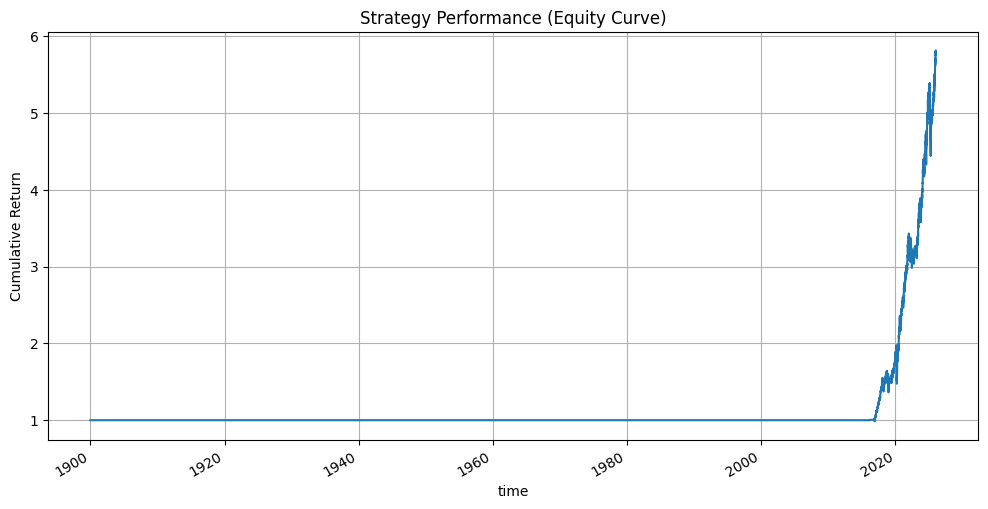

Final Portfolio Value: 5775223.0465903655
Total Return: 477.52230465904023 %


In [6]:
import matplotlib.pyplot as plt

perf = result.porfolio_performance
perf['performance'].plot(figsize=(12, 6), title="Strategy Performance (Equity Curve)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

print("Final Portfolio Value:", perf['value'].iloc[-1])
print("Total Return:", (perf['performance'].iloc[-1] - 1) * 100, "%")